In [44]:
"""
updated 2019-08-08 
written by Minhae Kwon

- `recoding`: Estimate the next belief from current belief and observations
    - input:
        - if you use POMDP data (for now): `recoding_pomdp_all_prev_df.csv` and `recoding_pomdp_all_now_df.csv`
        - ideally with neural data: `recoding_neural_all_prev_df.csv` and `recoding_neural_all_now_df.csv`
    - output: `recoding_belief_results_df.csv` (estimated future belief)
    - method: Autoregression - this is linear regression between two time steps. 
    - there are two versions in codes:
        -`recoding_wo_RBF.ipynb`: no RBF is used. 
        - `recoding_KRR.ipynb`: RBF is used using sklearn built-in function: [Kernel Ridge Regression (kernel ='rbf')](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html). 
        (Warning: this code runs pretty slow compared to others. So if you need to handle big data size, plan in advance!)
        - `recoding_manualRBF.ipynb`: RBF is manually coded by me. So we can customize center locations for nonlinear transform. 
        Everything is the same as `recoding_wo_RBF.ipynb` but RBF.
        - `recoding_KRR.ipynb` works the best, and pretty good!

ref: https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b
https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html
https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression
https://scikit-learn.org/stable/auto_examples/plot_kernel_ridge_regression.html#sphx-glr-auto-examples-plot-kernel-ridge-regression-py

ref: https://chrisalbon.com/machine_learning/linear_regression/linear_regression_using_scikit-learn/
     https://datatofish.com/multiple-linear-regression-python/

cross validate score: Coefficient of determination
https://en.wikipedia.org/wiki/Coefficient_of_determination
"""

from pandas import DataFrame, read_csv
#from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score
#from sklearn.pipeline import Pipeline
from sklearn.kernel_ridge import KernelRidge
import numpy as np
import matplotlib.pyplot as plt
import itertools

#bb_df = read_csv('./data/bb_df.csv') #behavior belief =[belief for box1, beleif for box2]
bb_df_prev = read_csv('./data/recoding_pomdp_all_prev_df.csv') #behavior belief =[belief for box1, beleif for box2]
bb_df_now = read_csv('./data/recoding_pomdp_all_now_df.csv') #behavior belief =[belief for box1, beleif for box2]


TEST_SIZE = 0.2  # ratio of test data set 
N_SPLITS = 10 # "K" in K-fold cross validation 

In [45]:
data = bb_df_prev #.to_numpy()
y_raw = bb_df_now[['behavior_belief1', 'behavior_belief2']].to_numpy()#[:1000].to_numpy()


### RBF starats here

In [46]:
def RBF(X_set, centers, gamma=1):
    X_RBF_set = np.ones((X_set.shape[0], centers.shape[0])) # number of data set * number of center ponts
    for i in range(X_set.shape[0]):
        X = X_set[i] #i-th data
        X_RBF = np.exp(-1*1/gamma/2*np.linalg.norm(X-centers,2, axis = 1)**2)
        X_RBF_set[i] = X_RBF
    return X_RBF_set
    

In [47]:
nb_raw = data[['behavior_belief1', 'behavior_belief2']].to_numpy()#[:1000] # for time constraint, I tested only 1000 data points
a = data['action'].to_numpy()#[:1000]
loc_raw = data['location'].to_numpy()#[:1000]
rwd_raw = data['reward'].to_numpy()
clr_raw = data[['color 1', 'color 2']].to_numpy()


center = np.linspace(0.05,1.05,11)[:10]
loc = np.array([0, 1, 2])
rwd = np.array([0, 1])
clr = np.array([0, 1, 2, 3, 4])


centers_b = []
centers_loc =[]
centers_rwd = []
centers_clr =[]


for i in itertools.product(center,center):
    centers_b.append(i)
for j in itertools.product(loc):
    centers_loc.append(j)
for k in itertools.product(rwd):
    centers_rwd.append(k)
for c in itertools.product(clr, clr):
    centers_clr.append(c)
    
centers_b = np.array(centers_b)
centers_loc = np.array(centers_loc)
centers_rwd = np.array(centers_rwd)
centers_clr = np.array(centers_clr)

# nonlinear transform using RBF: belief and location are transformed individually
# gamma in here is the variance term in gaussian equation
nb = RBF(nb_raw, centers_b, gamma=0.5) 
loc = RBF(loc_raw, centers_loc, gamma=0.5)
rwd = RBF(rwd_raw, centers_rwd, gamma=0.5) 
clr = RBF(clr_raw, centers_clr, gamma=0.5)
y = RBF(y_raw, centers_b, gamma=0.5) 


nb_all = np.concatenate((nb, loc, rwd, clr),axis=1)    

In [48]:
X = nb_all
y = y

### there are 3 types of data: test data, train data, validation data

In [49]:
# separate test data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state = 1)

In [50]:
regr = LinearRegression(n_jobs = -1) # linear regression is used for encoding process
#regr = KernelRidge(alpha=0.01, gamma=0.1, kernel='rbf') # linear regression(small gamma) with RBF kernel

In [51]:
# now we use only train data 
# why use StratifiedKFold?: The folds are made by preserving the percentage of samples for each class.
k_fold = StratifiedKFold(n_splits=N_SPLITS) # seperate train data and validation data

In [52]:
# why argmax(1)? split cannot simply handle multidimension y. 
# ref: https://stackoverflow.com/questions/48508036/sklearn-stratifiedkfold-valueerror-supported-target-types-are-binary-mul
for i, (train_index, val_index) in enumerate(k_fold.split(X, y.argmax(1))):
    #print("TRAIN:", train_index, "TEST:", val_index)
    x_train_kf, x_val_kf = X[train_index], X[val_index]
    y_train_kf, y_val_kf = y[train_index], y[val_index]
    #print(x_train_kf)
    #print(y_train_kf)
    regr.fit(x_train_kf, y_train_kf) # fit the model
    nb_val = regr.predict(x_val_kf) # predict based on current model -> use validation data for evaluation
    print('score', r2_score(y_val_kf, nb_val, multioutput='raw_values')) # get r2 score

score [0.4836444  0.48346824 0.4843174  0.48743246 0.4937163  0.50260681
 0.51251863 0.52160866 0.52880858 0.53397024 0.48766739 0.4831015
 0.47832451 0.47556644 0.47810606 0.48727135 0.50061144 0.51389781
 0.52464222 0.53240972 0.49400346 0.48469593 0.47164531 0.45744491
 0.45002614 0.45796135 0.47812513 0.49962995 0.51649883 0.52814119
 0.50311048 0.48979795 0.46699624 0.43305201 0.40043318 0.40136932
 0.43740761 0.4759821  0.50323557 0.5205387  0.51424133 0.49951054
 0.46972471 0.41255124 0.33120132 0.30856695 0.37687264 0.44452146
 0.48595518 0.50994486 0.52545615 0.51222637 0.48274963 0.4187089
 0.3069581  0.25150899 0.3342166  0.41962034 0.46997515 0.49857482
 0.53454147 0.52424509 0.50070446 0.45107228 0.3686302  0.31565633
 0.35525752 0.41759143 0.46184347 0.48954878 0.54031358 0.53279105
 0.5156997  0.48267263 0.43419485 0.39784283 0.40344473 0.43317541
 0.46246871 0.48456329 0.54290481 0.53741693 0.52506298 0.50298879
 0.47298749 0.4478486  0.44150781 0.45185446 0.46792782 0.

score [0.47747532 0.47441454 0.47198874 0.47224274 0.47691067 0.48622827
 0.4983407  0.51065523 0.52135244 0.52961636 0.48372124 0.47611618
 0.46748264 0.46083424 0.4607667  0.47010695 0.48617931 0.50336767
 0.51809532 0.52906944 0.49293688 0.48073174 0.46366213 0.44442498
 0.4328962  0.44037285 0.46382997 0.49026656 0.51132112 0.52609736
 0.50500923 0.48988493 0.46373324 0.42426748 0.38545661 0.38472563
 0.42469156 0.46864235 0.49988084 0.51982355 0.5189292  0.50360227
 0.47219132 0.4111777  0.3231648  0.29664217 0.36796403 0.44014764
 0.4843749  0.51015486 0.53161173 0.51886878 0.48945472 0.4244357
 0.30879167 0.24798061 0.33024598 0.41711055 0.46932126 0.49878303
 0.54097622 0.53125464 0.50813285 0.45814943 0.3732178  0.31564085
 0.35297573 0.4153712  0.46045668 0.48876052 0.54579292 0.53838022
 0.52109721 0.48693886 0.43575549 0.39580193 0.39972766 0.42941599
 0.45935456 0.48213012 0.54667739 0.54079155 0.52749925 0.50370576
 0.47111344 0.44329278 0.4356311  0.4461335  0.46291417 0

### Linear regression model: 

In [53]:
print('Intercept: ', regr.intercept_)
print('Coef: ', regr.coef_)

Intercept:  [ 6.54172080e+11  5.34744256e+11  3.94541137e+11  2.41084764e+11
  8.29699550e+10 -7.09293324e+10 -2.12281966e+11 -3.34044392e+11
 -4.31035853e+11 -5.00279515e+11  6.20739284e+11  4.90914799e+11
  3.40638479e+11  1.78013348e+11  1.21730381e+10 -1.47563903e+11
 -2.92558136e+11 -4.15621001e+11 -5.11597810e+11 -5.77698082e+11
  5.68854974e+11  4.30328626e+11  2.72189749e+11  1.03007130e+11
 -6.76916346e+10 -2.30304664e+11 -3.76047103e+11 -4.97734522e+11
 -5.90361567e+11 -6.51412127e+11  5.01206099e+11  3.56135561e+11
  1.92767813e+11  1.99974602e+10 -1.52420177e+11 -3.14777098e+11
 -4.58314603e+11 -5.76003072e+11 -6.63103323e+11 -7.17448430e+11
  4.21681510e+11  2.72593763e+11  1.06927551e+11 -6.62547769e+10
 -2.37149295e+11 -3.96125400e+11 -5.34621331e+11 -6.45904894e+11
 -7.25605761e+11 -7.71962148e+11  3.35006780e+11  1.84670404e+11
  1.97789759e+10 -1.50605359e+11 -3.16812349e+11 -4.69468358e+11
 -6.00368617e+11 -7.03204497e+11 -7.74056565e+11 -8.11601284e+11
  2.46282569e

### evaluate model with test data

In [54]:
predic_X_test = regr.predict(X_test)

recoding_error = y_test - predic_X_test # true - estimate
print('recoding MSE: \n', np.mean(recoding_error**2, axis=0))
print('recoding error std:\n', np.std(recoding_error, axis=0))      
print('score', r2_score(y_test, predic_X_test, multioutput='raw_values'))

recoding MSE: 
 [0.02093795 0.02009646 0.01905242 0.01817733 0.01777962 0.01803349
 0.01892691 0.020261   0.02169623 0.022847   0.0200832  0.01849566
 0.01675131 0.01530976 0.01456492 0.01473999 0.01583009 0.01759868
 0.01963808 0.02146955 0.0189751  0.01664361 0.01419912 0.01219629
 0.01110745 0.01120318 0.01248559 0.01468246 0.01731739 0.0198276
 0.01800877 0.01502139 0.0119634  0.0094706  0.00808291 0.00811298
 0.00956629 0.01214066 0.01529906 0.0184009  0.01753637 0.01407266
 0.01056601 0.00771611 0.00611401 0.00610233 0.00768974 0.01054691
 0.01409112 0.01762344 0.01778545 0.01408402 0.01035283 0.00732443
 0.00562025 0.00559834 0.00726584 0.01027763 0.01402086 0.01776426
 0.01878167 0.01511439 0.01140664 0.00839863 0.00671485 0.00671443
 0.00839982 0.01141918 0.01515096 0.01885667 0.02034507 0.01696729
 0.01352239 0.01072395 0.00917696 0.00922379 0.01085868 0.01373808
 0.01725127 0.02068547 0.02212619 0.0192447  0.01625465 0.01382144
 0.01250059 0.0126088  0.0141336  0.01674193 0.

In [55]:
predic_X_df_test = DataFrame(predic_X_test) 

In [56]:
predic_X_test


array([[0.40673828, 0.44506836, 0.4788208 , ..., 0.88769531, 0.85583496,
        0.80932617],
       [0.48327637, 0.49975586, 0.50811768, ..., 0.78027344, 0.71264648,
        0.63806152],
       [0.36181641, 0.4017334 , 0.43914795, ..., 0.90930176, 0.88525391,
        0.84667969],
       ...,
       [0.35021973, 0.39544678, 0.43798828, ..., 0.90612793, 0.89355469,
        0.8651123 ],
       [0.29370117, 0.33776855, 0.38098145, ..., 0.92163086, 0.92077637,
        0.9029541 ],
       [0.62695312, 0.70794678, 0.7835083 , ..., 0.5682373 , 0.56750488,
        0.55529785]])

### Plot in below is different from 'recoding_KRR.ipynb'. This is RBF(belief) to RBF(belief), and 'recoding_KRR.ipynb' is belief to belief. 

Text(0.5, 1.0, 'Recoding')

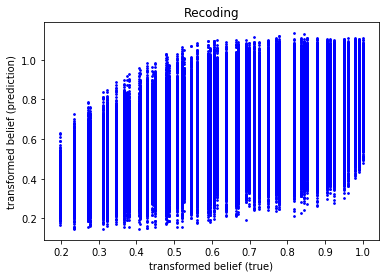

In [57]:
# plot: compare raw data vs prediction
plt.scatter(y_test, predic_X_test, s=3, c='blue', marker='o')
plt.xlabel('transformed belief (true)')
plt.ylabel('transformed belief (prediction)')
plt.title('Recoding')

### build csv file

In [43]:
"""
#neural estimate of belief using current linear regression model
nb= regr.predict(r_df) 
nb_df = DataFrame(nb, columns = bb_df.columns)
#save neural estimate belief
nb_df.to_csv(path_or_buf='./data/nb_df.csv',index=False)
"""

"\n#neural estimate of belief using current linear regression model\nnb= regr.predict(r_df) \nnb_df = DataFrame(nb, columns = bb_df.columns)\n#save neural estimate belief\nnb_df.to_csv(path_or_buf='./data/nb_df.csv',index=False)\n"